# Library Imports and Data handling

In [3]:
import numpy as np
import skimage.io
import skimage.color
from matplotlib import pyplot as plt
import numpy as np
import cv2
from numpy import load
import pandas as pd
import xml.etree.ElementTree as et
import numpy as np
import os
from matplotlib import pyplot as plt

from skimage import img_as_float
from skimage.io import imread_collection,imread
from skimage.color import rgb2gray
from skimage.transform import resize
import pandas as pd
import decimal
decimal.getcontext().prec = 100
#For testing
from sklearn.datasets import make_blobs

data = load('bloodmnist.npz')
lst = data.files
xtrain = data[lst[0]]
ytrain = data[lst[1]]
xval = data[lst[2]]
yval = data[lst[3]]
xtest = data[lst[4]]
ytest = data[lst[5]]

xtrain = (xtrain[:,:,:,0]+xtrain[:,:,:,1]+xtrain[:,:,:,2])/3
xval = (xval[:,:,:,0]+xval[:,:,:,1]+xval[:,:,:,2])/3
xtest = (xtest[:,:,:,0]+xtest[:,:,:,1]+xtest[:,:,:,2])/3

xtrain = np.reshape(xtrain,(-1,28*28))
ytrain = np.reshape(ytrain,(11959,1))
xval = np.reshape(xval,(-1,28*28))
yval = np.reshape(yval,(1712,1))
xtest = np.reshape(xtest,(-1,28*28))
ytest = np.reshape(ytest,(3421,1))

# Performance Metric  and Preprocessing Related Functions

In [119]:
def MeanSquaredError(ydata,ypredict):
  return np.sqrt(np.mean(np.square(ydata-ypredict)))

def ReturnConfMatrix(ypredict,ytest,N=2):
  Conf = np.zeros((N,N))
  for i in range(N):
    for j in range(N):
      a = np.where(ypredict==i,1,0)
      b = np.where(ytest==j,1,0)
      c = a*b
      Conf[i,j] = np.sum(c)
  return Conf

def EvaluateAccuracy(ypredict,ytest,N=2):
  Conf = ReturnConfMatrix(ypredict,ytest,N)
  I = np.identity(N)
  Diag = Conf*I
  return np.sum(Diag)/max(np.sum(Conf),0.001)

def EvaluatePrecision(ypredict,ytest,i,N=2):
  Conf = ReturnConfMatrix(ypredict,ytest,N)
  return max(Conf[i,i],0.001)/max(np.sum(Conf[i,:]),0.001)

def EvaluateRecall(ypredict,ytest,i,N=2):
  Conf = ReturnConfMatrix(ypredict,ytest,N)
  return max(Conf[i,i],0.001)/max(np.sum(Conf[:,i]),0.001)

def EvaluateF1score(ypredict,ytest,i,N=2):
  p = EvaluatePrecision(ypredict,ytest,i,N)
  r = EvaluateRecall(ypredict,ytest,i,N)
  return 2*r*p/(r+p)

def EvaluateFalsePositiveRate(ypredict,ytest,i,N=2):
  Conf = ReturnConfMatrix(ypredict,ytest,N)
  t1=max(np.sum(Conf[i,:]),0.001)
  t2=t1-Conf[i,i]
  t3=max(t2,0.001)
  return t3/max(np.sum(Conf[i,:]),0.001)

def EvaluateAUC(ypredict,ytest,i,N=2):
  return EvaluatePrecision(ypredict,ytest,i,N)/EvaluateFalsePositiveRate(ypredict,ytest,i,N)

def EvaluateCategoricalCrossEntropy(ypredict,ytest):
  return np.abs(np.sum(np.log(ypredict)@ytest.transpose()))


def plot(errors,iter,title=''):
  plt.title(title)
  plt.plot(range(iter),errors)
  plt.xticks(np.linspace(start=0,stop=iter,num=11))
  plt.xlabel('Iterations')
  plt.ylabel('MeanSquaredError')
  plt.show()
  plt.clf()





class OneHotEncoder:

  def __init__(self,classes=2,type='none'):
    self.classes = classes
    self.type = type
    pass

  def transform(self,X:np.ndarray):
    self.classes = int(np.max(X)+1)
    if self.type=='none':
      Y = -1*np.ones((len(X),self.classes))
    else:
      Y = np.zeros((len(X),self.classes))

    for i in range(len(X)):
      Y[i,X[i]] = 1
    return Y

  def inverse_transform(self,X:np.ndarray):
    Y = np.zeros(len(X))
    for i in range(len(X)):
      Y[i] = 0
      mx = X[i,0]
      for j in range(self.classes):
        if X[i,j] > mx:
          Y[i] = j
          mx = X[i,j] 
    return Y

class StandardScaler:

  def __init__(self):
    pass
  
  def fit(self,X:np.ndarray):
    self.mean = np.mean(X)
    self.std = np.std(X)
  
  def transform(self,X:np.ndarray):
    return (X-self.mean)/self.std

  def inverse_transform(self,X:np.ndarray):
    return X*self.std+self.mean

class TrainTestSplitter:

  def __init__(self,X,Y):
    self.X = X
    self.Y = Y
    self.len = len(X)
    self.idx = np.arange(self.len)
    pass
  
  def split(self,n=0.9):
    np.random.shuffle(self.idx)
    return self.X[self.idx[:int(n*self.len)]],self.Y[self.idx[:int(n*self.len)]],self.X[self.idx[int(n*self.len):]],self.Y[self.idx[int(n*self.len):]]


xdata,ydata = make_blobs(n_samples=1000,n_features=700,centers=10)

x_scalar = StandardScaler()
x_scalar.fit(xdata)
xdata = x_scalar.transform(xdata)

tts = TrainTestSplitter(xdata,ydata)
xdata,ydata,xtest,ytest = tts.split(0.75)
encoder = OneHotEncoder()
ydata = encoder.transform(ydata)



In [5]:
def tptnfpfn(ypredict,ytest,N=2):
  Conf = np.zeros((N,N))
  for i in range(N):
    for j in range(N):
      a = np.where(ypredict==i,1,0)
      b = np.where(ytest==j,1,0)
      c = a*b
      Conf[i,j] = np.sum(c)
  tp=np.zeros(8)
  tn=np.zeros(8)
  fp=np.zeros(8)
  fn=np.zeros(8)
  for i in range(N):
        tp[i]=Conf[i,i]
  ConfSum=np.sum(Conf)
  for i in range(N):
        for j in range(N):
            fp[i]+=Conf[j,i]
            fn[i]+=Conf[i,j]
        temp1=fp[i]
        temp2=fn[i]
        fp[i]-=Conf[i,i]
        fn[i]-=Conf[i,i]
        tn[i]=ConfSum-temp1-temp2+Conf[i,i]
    
  return tp,tn,fp,fn 
  

# MLE

In [6]:
class GaussianMaxLikelihoodEstimate:

  def __init__(self):
    pass
  
  def fit(self,X:np.ndarray):
    self.mean = np.mean(X,axis=0)
    self.cov = np.cov(X.transpose())
    self.cov = self.cov + 0.01*np.identity(self.cov.shape[0])
    self.det = np.linalg.det(self.cov)
    self.inv = np.linalg.inv(self.cov)
    pass
  
  def predict(self,x):
    x = x-self.mean
    return np.exp(-1*(x@(self.inv)@x)/2)

class GaussianBayesClassifier:

  def __init__(self):
    pass
  
  def fit(self,X:np.ndarray,Y:np.ndarray,validation_data=False):
    self.classes = 8
    #self.classes = int(np.round(np.max(Y)+1))
    self.Gmles = []
    for j in range(self.classes):
      data = []

      for x,y in zip(X,Y):
        if y[j]==1:
          data.append(x)

      data = np.array(data)
      gmle = GaussianMaxLikelihoodEstimate()
      gmle.fit(data)
      self.Gmles.append(gmle)
    
    if type(validation_data)!=bool:
      return EvaluateAccuracy(self.batchPrediction(validation_data[0]),validation_data[1],self.classes)
  
  def predict(self,x):
    curr=-1
    mx=-1
    mx = 0
    for i,gmle in enumerate(self.Gmles):
      res = gmle.predict(x)
      if res > curr:
        mx = i
        curr = res
    return mx


  def batchPrediction(self,X:np.ndarray):
    ypredict = np.zeros(X.shape[0])
    for i in range(X.shape[0]):
      ypredict[i] = self.predict(X[i,:])
    return ypredict


In [57]:
data = load('bloodmnist.npz')
lst = data.files
xtrain = data[lst[0]]
ytrain = data[lst[1]]
xval = data[lst[2]]
yval = data[lst[3]]
xtest = data[lst[4]]
ytest = data[lst[5]]

xtrain = (xtrain[:,:,:,0]+xtrain[:,:,:,1]+xtrain[:,:,:,2])/3
xval = (xval[:,:,:,0]+xval[:,:,:,1]+xval[:,:,:,2])/3
xtest = (xtest[:,:,:,0]+xtest[:,:,:,1]+xtest[:,:,:,2])/3


xtrain = np.reshape(xtrain,(-1,28*28))
ytrain = np.reshape(ytrain,(11959,1))
xval = np.reshape(xval,(-1,28*28))
yval = np.reshape(yval,(1712,1))
xtest = np.reshape(xtest,(-1,28*28))
ytest = np.reshape(ytest,(3421,1))


x_scalar = StandardScaler()
x_scalar.fit(xtrain)
xtrain = x_scalar.transform(xtrain)
xval = x_scalar.transform(xval)
xtest = x_scalar.transform(xtest)


encoder = OneHotEncoder(8,type='zeros')

ytrain = encoder.transform(ytrain)



In [58]:
ytrain.shape

(11959, 8)

In [59]:
ytest.shape

(3421, 1)

In [36]:
gm = GaussianBayesClassifier()
gm.fit(xtrain,ytrain,validation_data=(xval,yval))
ypredict = gm.batchPrediction(xtest)
print(ypredict.shape)
ypredict=np.reshape(ypredict,(3421,1))
print(ypredict.shape)
EvaluateAccuracy(ypredict,ytest,8)
for i in range(len(gm.Gmles)):
    f1 = EvaluateF1score(ypredict,ytest,i,len(gm.Gmles))
    print(f'F1 Score : {i} = {f1:.3f}')
    
for i in range(len(gm.Gmles)):
  f1 = EvaluateAUC(ypredict,ytest,i,len(gm.Gmles))
  print(f'EvaluateAUC : {i} = {f1:.3f}')

gm = GaussianBayesClassifier()
gm.fit(xtrain,ytrain,validation_data=(xval,yval))
print(ReturnConfMatrix(ypredict,ytest,8))


(3421,)
F1 Score : 0 = 0.099
F1 Score : 1 = 0.004


<ipython-input-34-67a4d037db8f>:37: RuntimeWarning: invalid value encountered in double_scalars
  return 2*r*p/(r+p)


F1 Score : 2 = nan
F1 Score : 3 = 0.198
F1 Score : 4 = nan
F1 Score : 5 = nan
F1 Score : 6 = 0.293
F1 Score : 7 = 0.004
AUC : 0 = 0.077
AUC : 1 = 0.223
AUC : 2 = 0.000
AUC : 3 = 0.204
AUC : 4 = 0.000
AUC : 5 = 0.000
AUC : 6 = 0.242
AUC : 7 = 0.159
[[ 135908.  347568.  173227.  322503.  135351.  158188.  370962.  261790.]
 [   1708.    4368.    2177.    4053.    1701.    1988.    4662.    3290.]
 [      0.       0.       0.       0.       0.       0.       0.       0.]
 [ 198372.  507312.  252843.  470727.  197559.  230892.  541458.  382110.]
 [      0.       0.       0.       0.       0.       0.       0.       0.]
 [      0.       0.       0.       0.       0.       0.       0.       0.]
 [ 497028. 1271088.  633507. 1179423.  494991.  578508. 1356642.  957390.]
 [   1708.    4368.    2177.    4053.    1701.    1988.    4662.    3290.]]


In [60]:
ypredict=np.reshape(ypredict,(3421,1))
ytest=np.reshape(ytest,(3421,1))

In [61]:
print(ReturnConfMatrix(ypredict,ytest,8))

[[ 60.  63.  23. 125.  43.  57. 168.  18.]
 [  1.   5.   0.   0.   0.   0.   1.   0.]
 [  0.   0.   0.   0.   0.   0.   0.   0.]
 [ 32. 168.  81. 183.  44. 148.  27. 130.]
 [  0.   0.   0.   0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.   0.   0.   0.]
 [151. 388. 207. 271. 156.  79. 470. 315.]
 [  0.   0.   0.   0.   0.   0.   0.   7.]]


In [62]:
print(ypredict.shape)

(3421, 1)


In [63]:
print(ytest.shape)

(3421, 1)


In [64]:
Conf=ReturnConfMatrix(ypredict,ytest,8)
np.sum(Conf)

3421.0

In [65]:
tp,tn,fp,fn=tptnfpfn(ypredict,ytest,8)
print(tp)
print(tn)
print(fp)
print(fn)

[ 60.   5.   0. 183.   0.   0. 470.   7.]
[2680. 2795. 3110. 2212. 3178. 3137. 1188. 2951.]
[184. 619. 311. 396. 243. 284. 196. 463.]
[ 497.    2.    0.  630.    0.    0. 1567.    0.]


In [66]:
EvaluateAccuracy(ypredict,ytest,8)

0.2119263373282666

In [67]:

EvaluateAccuracy(ypredict,ytest,8)
for i in range(len(gm.Gmles)):
    f1 = EvaluateF1score(ypredict,ytest,i,len(gm.Gmles))
    print(f'F1 Score : {i} = {f1:.3f}')
    
for i in range(len(gm.Gmles)):
  f1 = EvaluateAUC(ypredict,ytest,i,len(gm.Gmles))
  print(f'EvaluateAUC : {i} = {f1:.3f}')

gm = GaussianBayesClassifier()
gm.fit(xtrain,ytrain,validation_data=(xval,yval))
print(ReturnConfMatrix(ypredict,ytest,8))

F1 Score : 0 = 0.150
F1 Score : 1 = 0.016
F1 Score : 2 = nan
F1 Score : 3 = 0.263
F1 Score : 4 = nan
F1 Score : 5 = nan
F1 Score : 6 = 0.348
F1 Score : 7 = 0.029
AUC : 0 = 0.121
AUC : 1 = 2.500
AUC : 2 = 0.000
AUC : 3 = 0.290
AUC : 4 = 0.000
AUC : 5 = 0.000
AUC : 6 = 0.300
AUC : 7 = inf


<ipython-input-49-c78b54de6ef2>:37: RuntimeWarning: invalid value encountered in double_scalars
  return 2*r*p/(r+p)
<ipython-input-49-c78b54de6ef2>:44: RuntimeWarning: divide by zero encountered in double_scalars
  return precision(ypredict,ytest,i,N)/FPR(ypredict,ytest,i,N)


[[ 60.  63.  23. 125.  43.  57. 168.  18.]
 [  1.   5.   0.   0.   0.   0.   1.   0.]
 [  0.   0.   0.   0.   0.   0.   0.   0.]
 [ 32. 168.  81. 183.  44. 148.  27. 130.]
 [  0.   0.   0.   0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.   0.   0.   0.]
 [151. 388. 207. 271. 156.  79. 470. 315.]
 [  0.   0.   0.   0.   0.   0.   0.   7.]]


In [120]:
data = load('bloodmnist.npz')
lst = data.files
xtrain = data[lst[0]]
ytrain = data[lst[1]]
xval = data[lst[2]]
yval = data[lst[3]]
xtest = data[lst[4]]
ytest = data[lst[5]]

xtrain = (xtrain[:,:,:,0]+xtrain[:,:,:,1]+xtrain[:,:,:,2])/3
xval = (xval[:,:,:,0]+xval[:,:,:,1]+xval[:,:,:,2])/3
xtest = (xtest[:,:,:,0]+xtest[:,:,:,1]+xtest[:,:,:,2])/3


xtrain = np.reshape(xtrain,(-1,28*28))
ytrain = np.reshape(ytrain,(11959,1))
xval = np.reshape(xval,(-1,28*28))
yval = np.reshape(yval,(1712,1))
xtest = np.reshape(xtest,(-1,28*28))
ytest = np.reshape(ytest,(3421,1))


x_scalar = StandardScaler()
x_scalar.fit(xtrain)
xtrain = x_scalar.transform(xtrain)
xval = x_scalar.transform(xval)
xtest = x_scalar.transform(xtest)


encoder = OneHotEncoder(8,type='zeros')

ytrain = encoder.transform(ytrain)


gm = GaussianBayesClassifier()
gm.fit(xtrain,ytrain,validation_data=(xval,yval))
ypredict = gm.batchPrediction(xtest)



In [121]:
ypredict=np.reshape(ypredict,(3421,1))
ytest=np.reshape(ytest,(3421,1))
print(EvaluateAccuracy(ypredict,ytest,8))
for i in range(len(gm.Gmles)):
    f1 = EvaluatePrecision(ypredict,ytest,i,len(gm.Gmles))
    print(f'EvaluatePrecision : {i} = {f1:.3f}')
    
for i in range(len(gm.Gmles)):
    f1 = EvaluateRecall(ypredict,ytest,i,len(gm.Gmles))
    print(f'EvaluateRecall : {i} = {f1:.3f}')
    
for i in range(len(gm.Gmles)):
    f1 = EvaluateF1score(ypredict,ytest,i,len(gm.Gmles))
    print(f'F1 Score : {i} = {f1:.3f}')
    
for i in range(len(gm.Gmles)):
  f1 = EvaluateAUC(ypredict,ytest,i,len(gm.Gmles))
  print(f'EvaluateAUC : {i} = {f1:.3f}')

print(ReturnConfMatrix(ypredict,ytest,8))

tp,tn,fp,fn=tptnfpfn(ypredict,ytest,8)
print(tp)
print(tn)
print(fp)
print(fn)

0.2119263373282666
precision : 0 = 0.108
precision : 1 = 0.714
precision : 2 = 1.000
precision : 3 = 0.225
precision : 4 = 1.000
precision : 5 = 1.000
precision : 6 = 0.231
precision : 7 = 1.000
recall : 0 = 0.246
recall : 1 = 0.008
recall : 2 = 0.000
recall : 3 = 0.316
recall : 4 = 0.000
recall : 5 = 0.000
recall : 6 = 0.706
recall : 7 = 0.015
F1 Score : 0 = 0.150
F1 Score : 1 = 0.016
F1 Score : 2 = 0.000
F1 Score : 3 = 0.263
F1 Score : 4 = 0.000
F1 Score : 5 = 0.000
F1 Score : 6 = 0.348
F1 Score : 7 = 0.029
AUC : 0 = 0.121
AUC : 1 = 2.500
AUC : 2 = 1.000
AUC : 3 = 0.290
AUC : 4 = 1.000
AUC : 5 = 1.000
AUC : 6 = 0.300
AUC : 7 = 7000.000
[[ 60.  63.  23. 125.  43.  57. 168.  18.]
 [  1.   5.   0.   0.   0.   0.   1.   0.]
 [  0.   0.   0.   0.   0.   0.   0.   0.]
 [ 32. 168.  81. 183.  44. 148.  27. 130.]
 [  0.   0.   0.   0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.   0.   0.   0.]
 [151. 388. 207. 271. 156.  79. 470. 315.]
 [  0.   0.   0.   0.   0.   0.   0.   7.]]
[ 60.   5

# Logistic Regression

In [68]:
class LogisticRegressor:
    
    def __init__(self):
      pass

    def preprocess(self,x):
      d = len(x)
      x_new = np.ones(d+1)
      k=0
      for i in x:
          x_new[k] = i
          k+=1
      return x_new
  
    def batchPreprocessing(self,X):
      d = X.shape[1]
      X_new = np.zeros((X.shape[0],d+1))
      for i in range(X.shape[0]):
        X_new[i] = self.preprocess(X[i])
      return X_new
    
    def fit(self,X:np.ndarray,Y:np.ndarray,iter=20,alpha=1,beta=0.9,gamma=0.01,validation_data=False,regularization='none'):
      '''
      X : Input batch
      Y : Output batch
      iter : Iterations
      alpha : step-size
      beta : step-size decay
      gamma : regularization parameter
      regularization : {'none','L1','L2','Elastic'}
      '''

      X = self.batchPreprocessing(X)
      if validation_data!=False:
        xval = self.batchPreprocessing(validation_data[0])

      self.W = np.zeros((Y.shape[1],X.shape[1]))
      Y = np.reshape(Y,(len(Y),-1))
      
      errors = []
      for i in range(iter):
        for j in range(Y.shape[1]):
          if(regularization=='none'):
            self.W[j,:] = self.W[j,:] - alpha*((self.batchPrediction(X)*(1-self.batchPrediction(X)))[:,j]).transpose()@X/Y.shape[0]
          elif(regularization=='L2'):
            self.W[j,:] = self.W[j,:] - alpha*(((self.batchPrediction(X)*(1-self.batchPrediction(X)))[:,j]).transpose()@X/Y.shape[0] - gamma*self.W[j,:])
          elif(regularization=='L1'):
            self.W[j,:] = self.W[j,:] - alpha*(((self.batchPrediction(X)*(1-self.batchPrediction(X)))[:,j]).transpose()@X/Y.shape[0] - gamma*np.sign(self.W[j,:]))
          elif(regularization=='Elastic'):
            self.W[j,:] = self.W[j,:] - alpha*(((self.batchPrediction(X)*(1-self.batchPrediction(X)))[:,j]).transpose()@X/Y.shape[0] - gamma*np.sign(self.W[j,:]))

        alpha = beta*alpha

        if type(validation_data)!=bool:
          errors.append(EvaluateCategoricalCrossEntropy(self.batchPrediction(xval),validation_data[1]))

      return errors


    def predict(self,x:np.ndarray):
      if x.shape[0]!=self.W.shape[1]:
        x = self.preprocess(x)
      x = np.reshape(x,(len(x),-1))
      y = self.W@x
      for i in range(y.shape[0]):
        y[i] = 1/(1+np.exp(y[i]))
      y = np.reshape(y,(y.shape[0],))
      return y

    def batchPrediction(self,X:np.ndarray):
      ypredict = []
      for i in range(X.shape[0]):
        ypredict.append(self.predict(X[i,:]))

      ypredict = np.array(ypredict)
      return ypredict


In [69]:
data = load('bloodmnist.npz')
lst = data.files
xtrain = data[lst[0]]
ytrain = data[lst[1]]
xval = data[lst[2]]
yval = data[lst[3]]
xtest = data[lst[4]]
ytest = data[lst[5]]

xtrain = (xtrain[:,:,:,0]+xtrain[:,:,:,1]+xtrain[:,:,:,2])/3
xval = (xval[:,:,:,0]+xval[:,:,:,1]+xval[:,:,:,2])/3
xtest = (xtest[:,:,:,0]+xtest[:,:,:,1]+xtest[:,:,:,2])/3


xtrain = np.reshape(xtrain,(-1,28*28))
ytrain = np.reshape(ytrain,(11959,1))
xval = np.reshape(xval,(-1,28*28))
yval = np.reshape(yval,(1712,1))
xtest = np.reshape(xtest,(-1,28*28))
ytest = np.reshape(ytest,(3421,1))


x_scalar = StandardScaler()
x_scalar.fit(xtrain)
xtrain = x_scalar.transform(xtrain)
xval = x_scalar.transform(xval)
xtest = x_scalar.transform(xtest)


encoder = OneHotEncoder(8,type='zeros')

ytrain = encoder.transform(ytrain)



In [70]:
lm = LogisticRegressor()

iter = 50
errors1 = lm.fit(xtrain,ytrain,alpha=0.001,beta=1,iter=iter,validation_data=(xval,encoder.transform(yval)))
errors2 = lm.fit(xtrain,ytrain,alpha=0.001,beta=1,iter=iter,validation_data=(xval,encoder.transform(yval)),regularization='L1')
errors3 = lm.fit(xtrain,ytrain,alpha=0.001,beta=1,iter=iter,validation_data=(xval,encoder.transform(yval)),regularization='L2')
errors4 = lm.fit(xtrain,ytrain,alpha=0.001,beta=1,iter=iter,validation_data=(xval,encoder.transform(yval)),regularization='Elastic')

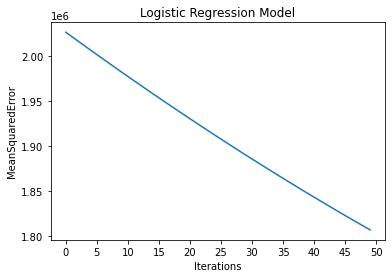

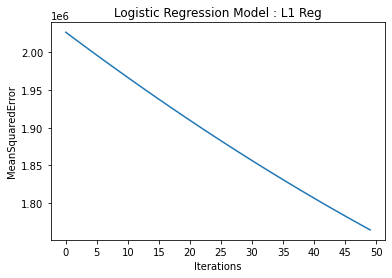

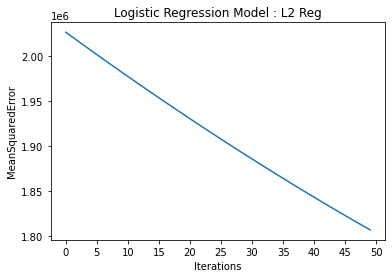

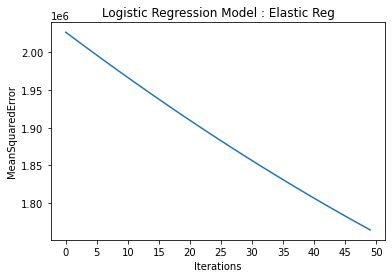

<Figure size 432x288 with 0 Axes>

In [71]:
plot(errors1,iter,'Logistic Regression Model')
plot(errors2,iter,'Logistic Regression Model : L1 Reg')
plot(errors3,iter,'Logistic Regression Model : L2 Reg')
plot(errors4,iter,'Logistic Regression Model : Elastic Reg')

In [74]:
ypredict = lm.batchPrediction(xtest)
encoder = OneHotEncoder()
ypredict = encoder.inverse_transform(ypredict)
ypredict=np.reshape(ypredict,(3421,1))
ytest=np.reshape(ytest,(3421,1))
EvaluateAccuracy(ypredict,ytest,8)
for i in range(len(gm.Gmles)):
    f1 = EvaluatePrecision(ypredict,ytest,i,len(gm.Gmles))
    print(f'EvaluatePrecision : {i} = {f1:.3f}')
    
for i in range(len(gm.Gmles)):
    f1 = EvaluateRecall(ypredict,ytest,i,len(gm.Gmles))
    print(f'EvaluateRecall : {i} = {f1:.3f}')
    
for i in range(len(gm.Gmles)):
    f1 = EvaluateF1score(ypredict,ytest,i,len(gm.Gmles))
    print(f'F1 Score : {i} = {f1:.3f}')
    
for i in range(len(gm.Gmles)):
  f1 = EvaluateAUC(ypredict,ytest,i,len(gm.Gmles))
  print(f'EvaluateAUC : {i} = {f1:.3f}')

print(ReturnConfMatrix(ypredict,ytest,8))

tp,tn,fp,fn=tptnfpfn(ypredict,ytest,8)
print(tp)
print(tn)
print(fp)
print(fn)

precision : 0 = 0.071
precision : 1 = 0.000
precision : 2 = 0.000
precision : 3 = 0.000
precision : 4 = 0.000
precision : 5 = 0.000
precision : 6 = 0.000
precision : 7 = 0.000
recall : 0 = 1.000
recall : 1 = 0.000
recall : 2 = 0.000
recall : 3 = 0.000
recall : 4 = 0.000
recall : 5 = 0.000
recall : 6 = 0.000
recall : 7 = 0.000
F1 Score : 0 = 0.133
F1 Score : 1 = nan
F1 Score : 2 = nan
F1 Score : 3 = nan
F1 Score : 4 = nan
F1 Score : 5 = nan
F1 Score : 6 = nan
F1 Score : 7 = nan
AUC : 0 = 0.077
AUC : 1 = 0.000
AUC : 2 = 0.000
AUC : 3 = 0.000
AUC : 4 = 0.000
AUC : 5 = 0.000
AUC : 6 = 0.000
AUC : 7 = 0.000
[[244. 624. 311. 579. 243. 284. 666. 470.]
 [  0.   0.   0.   0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.   0.   0.   0.]]
[244.   0.   0.   0.   0.   0.   0.   0.]
[  

<ipython-input-49-c78b54de6ef2>:37: RuntimeWarning: invalid value encountered in double_scalars
  return 2*r*p/(r+p)


In [92]:
lm.fit(xtrain,ytrain,alpha=0.001,beta=1,iter=iter,validation_data=(xval,encoder.transform(yval)))
ypredict = lm.batchPrediction(xtest)
encoder = OneHotEncoder()
ypredict = encoder.inverse_transform(ypredict)
ypredict=np.reshape(ypredict,(3421,1))
ytest=np.reshape(ytest,(3421,1))
EvaluateAccuracy(ypredict,ytest,8)
for i in range(len(gm.Gmles)):
    f1 = EvaluatePrecision(ypredict,ytest,i,len(gm.Gmles))
    print(f'EvaluatePrecision : {i} = {f1:.3f}')
    
for i in range(len(gm.Gmles)):
    f1 = EvaluateRecall(ypredict,ytest,i,len(gm.Gmles))
    print(f'EvaluateRecall : {i} = {f1:.3f}')
    
for i in range(len(gm.Gmles)):
    f1 = EvaluateF1score(ypredict,ytest,i,len(gm.Gmles))
    print(f'F1 Score : {i} = {f1:.3f}')
    
for i in range(len(gm.Gmles)):
  f1 = EvaluateAUC(ypredict,ytest,i,len(gm.Gmles))
  print(f'EvaluateAUC : {i} = {f1:.3f}')

print(ReturnConfMatrix(ypredict,ytest,8))

tp,tn,fp,fn=tptnfpfn(ypredict,ytest,8)
print(tp)
print(tn)
print(fp)
print(fn)

precision : 0 = 0.071
precision : 1 = 0.000
precision : 2 = 0.000
precision : 3 = 0.000
precision : 4 = 0.000
precision : 5 = 0.000
precision : 6 = 0.000
precision : 7 = 0.000
recall : 0 = 1.000
recall : 1 = 0.000
recall : 2 = 0.000
recall : 3 = 0.000
recall : 4 = 0.000
recall : 5 = 0.000
recall : 6 = 0.000
recall : 7 = 0.000
F1 Score : 0 = 0.133
F1 Score : 1 = nan
F1 Score : 2 = nan
F1 Score : 3 = nan
F1 Score : 4 = nan
F1 Score : 5 = nan
F1 Score : 6 = nan
F1 Score : 7 = nan
AUC : 0 = 0.077
AUC : 1 = 0.000
AUC : 2 = 0.000
AUC : 3 = 0.000
AUC : 4 = 0.000
AUC : 5 = 0.000
AUC : 6 = 0.000
AUC : 7 = 0.000
[[244. 624. 311. 579. 243. 284. 666. 470.]
 [  0.   0.   0.   0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.   0.   0.   0.]]
[244.   0.   0.   0.   0.   0.   0.   0.]
[  

<ipython-input-49-c78b54de6ef2>:37: RuntimeWarning: invalid value encountered in double_scalars
  return 2*r*p/(r+p)


In [93]:
lm.fit(xtrain,ytrain,alpha=0.001,beta=1,iter=iter,validation_data=(xval,encoder.transform(yval)),regularization='L1')
ypredict = lm.batchPrediction(xtest)
encoder = OneHotEncoder()
ypredict = encoder.inverse_transform(ypredict)
ypredict=np.reshape(ypredict,(3421,1))
ytest=np.reshape(ytest,(3421,1))
EvaluateAccuracy(ypredict,ytest,8)
for i in range(len(gm.Gmles)):
    f1 = EvaluatePrecision(ypredict,ytest,i,len(gm.Gmles))
    print(f'EvaluatePrecision : {i} = {f1:.3f}')
    
for i in range(len(gm.Gmles)):
    f1 = EvaluateRecall(ypredict,ytest,i,len(gm.Gmles))
    print(f'EvaluateRecall : {i} = {f1:.3f}')
    
for i in range(len(gm.Gmles)):
    f1 = EvaluateF1score(ypredict,ytest,i,len(gm.Gmles))
    print(f'F1 Score : {i} = {f1:.3f}')
    
for i in range(len(gm.Gmles)):
  f1 = EvaluateAUC(ypredict,ytest,i,len(gm.Gmles))
  print(f'EvaluateAUC : {i} = {f1:.3f}')

print(ReturnConfMatrix(ypredict,ytest,8))

tp,tn,fp,fn=tptnfpfn(ypredict,ytest,8)
print(tp)
print(tn)
print(fp)
print(fn)

precision : 0 = 0.071
precision : 1 = 0.000
precision : 2 = 0.000
precision : 3 = 0.000
precision : 4 = 0.000
precision : 5 = 0.000
precision : 6 = 0.000
precision : 7 = 0.000
recall : 0 = 1.000
recall : 1 = 0.000
recall : 2 = 0.000
recall : 3 = 0.000
recall : 4 = 0.000
recall : 5 = 0.000
recall : 6 = 0.000
recall : 7 = 0.000
F1 Score : 0 = 0.133
F1 Score : 1 = nan
F1 Score : 2 = nan
F1 Score : 3 = nan
F1 Score : 4 = nan
F1 Score : 5 = nan
F1 Score : 6 = nan
F1 Score : 7 = nan
AUC : 0 = 0.077
AUC : 1 = 0.000
AUC : 2 = 0.000
AUC : 3 = 0.000
AUC : 4 = 0.000
AUC : 5 = 0.000
AUC : 6 = 0.000
AUC : 7 = 0.000
[[244. 624. 311. 579. 243. 284. 666. 470.]
 [  0.   0.   0.   0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.   0.   0.   0.]]
[244.   0.   0.   0.   0.   0.   0.   0.]
[  

<ipython-input-49-c78b54de6ef2>:37: RuntimeWarning: invalid value encountered in double_scalars
  return 2*r*p/(r+p)


In [98]:
lm.fit(xtrain,ytrain,alpha=0.001,beta=1,iter=iter,validation_data=(xval,encoder.transform(yval)),regularization='L2')
ypredict = lm.batchPrediction(xtest)
encoder = OneHotEncoder()
ypredict = encoder.inverse_transform(ypredict)
ypredict=np.reshape(ypredict,(3421,1))
ytest=np.reshape(ytest,(3421,1))
print(EvaluateAccuracy(ypredict,ytest,8))
for i in range(len(gm.Gmles)):
    f1 = EvaluatePrecision(ypredict,ytest,i,len(gm.Gmles))
    print(f'EvaluatePrecision : {i} = {f1:.3f}')
    
for i in range(len(gm.Gmles)):
    f1 = EvaluateRecall(ypredict,ytest,i,len(gm.Gmles))
    print(f'EvaluateRecall : {i} = {f1:.3f}')
    
for i in range(len(gm.Gmles)):
    f1 = EvaluateF1score(ypredict,ytest,i,len(gm.Gmles))
    print(f'F1 Score : {i} = {f1:.3f}')
    
for i in range(len(gm.Gmles)):
  f1 = EvaluateAUC(ypredict,ytest,i,len(gm.Gmles))
  print(f'EvaluateAUC : {i} = {f1:.3f}')

print(ReturnConfMatrix(ypredict,ytest,8))

tp,tn,fp,fn=tptnfpfn(ypredict,ytest,8)
print(tp)
print(tn)
print(fp)
print(fn)

0.07132417421806489
precision : 0 = 0.071
precision : 1 = 0.000
precision : 2 = 0.000
precision : 3 = 0.000
precision : 4 = 0.000
precision : 5 = 0.000
precision : 6 = 0.000
precision : 7 = 0.000
recall : 0 = 1.000
recall : 1 = 0.000
recall : 2 = 0.000
recall : 3 = 0.000
recall : 4 = 0.000
recall : 5 = 0.000
recall : 6 = 0.000
recall : 7 = 0.000
F1 Score : 0 = 0.133
F1 Score : 1 = nan
F1 Score : 2 = nan
F1 Score : 3 = nan
F1 Score : 4 = nan
F1 Score : 5 = nan
F1 Score : 6 = nan
F1 Score : 7 = nan
AUC : 0 = 0.077
AUC : 1 = 0.000
AUC : 2 = 0.000
AUC : 3 = 0.000
AUC : 4 = 0.000
AUC : 5 = 0.000
AUC : 6 = 0.000
AUC : 7 = 0.000
[[244. 624. 311. 579. 243. 284. 666. 470.]
 [  0.   0.   0.   0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.   0.   0.   0.]]
[244.   0.   0.   0.   0.

<ipython-input-49-c78b54de6ef2>:37: RuntimeWarning: invalid value encountered in double_scalars
  return 2*r*p/(r+p)


# K Nearest Neighbour

In [75]:
class KNNclassifier:

  def __init__(self):
    pass
  
  def EUC_DIST(self,v1,v2): #function returning euclidean distance between any two vectors of equal dim
    v1,v2 = np.array(v1),np.array(v2)
    distance = np.sum((v1-v2)**2)
    return np.sqrt(distance)

  def Predict(self,k,Xtrain,Ytrain,Xtest_instance): # k = number of nearest neighb ,train_data = whole train array , test = only one single test image and its label
      distances = [] #array containing euc dist of test image with every training image respectively

      for i in range(len(Xtrain)):
          #print(i)
          dist = self.EUC_DIST(Xtrain[i], Xtest_instance)
          distances.append((Ytrain[i],dist)) 
    
      distances.sort(key=lambda x: x[1]) #sorting with least distance on top
    
      neighbors = []
      for i in range(k):
          neighbors.append(distances[i][0]) #contain array of labels of image with least euc dist to test image
        
      classes = {}
      for i in range(len(neighbors)):
            #response = neighbors[i][0]
            response = neighbors[i]
            #print(neighbors[i][0])
            if response in classes:
                classes[response] += 1
            else:
                classes[response] = 1
    
      sorted_classes = sorted(classes.items() , key = lambda x: x[1],reverse = True )
    
      return sorted_classes[0][0]  #return the predicted class/label of test img

  def batchPrediction(self,Knn,Xtrain,Ytrain,Xtest):
    #ypredict = np.zeros(Xtest.shape[0])
    ypredict=[]
    #print(ypredict.shape)
    for i in range(Xtest.shape[0]):
        #ypredict[i] = self.Predict(Knn,Xtrain,Ytrain,Xtest[i,:])
        ypredict.append(self.Predict(Knn,Xtrain,Ytrain,Xtest[i,:]))
    ypredict = np.array(ypredict)
    return ypredict
  

In [78]:


data = np.load('bloodmnist.npz')

lst = data.files
xtrain = data[lst[0]]
ytrain = data[lst[1]]
xval = data[lst[2]]
yval = data[lst[3]]
xtest = data[lst[4]]
ytest = data[lst[5]]

xtrain = np.reshape(xtrain,(11959,2352))
ytrain = np.reshape(ytrain,(11959))
xval = np.reshape(xval,(1712,2352))
yval = np.reshape(yval,(1712))
xtest = np.reshape(xtest,(3421,2352))
ytest = np.reshape(ytest,(3421))

x_scalar = StandardScaler()
x_scalar.fit(xtrain)
xtrain = x_scalar.transform(xtrain)
xval = x_scalar.transform(xval)
xtest = x_scalar.transform(xtest)


In [79]:
knn = KNNclassifier()
K = 11
ypredict = knn.batchPrediction(K,xtrain,ytrain,xtest)

In [83]:
ypredict=np.reshape(ypredict,(3421,1))
ytest=np.reshape(ytest,(3421,1))
#print(Eval_Acc(ypredict,ytest))
print(EvaluateAccuracy(ypredict,ytest,8))
for i in range(len(gm.Gmles)):
    f1 = EvaluatePrecision(ypredict,ytest,i,len(gm.Gmles))
    print(f'EvaluatePrecision : {i} = {f1:.3f}')
    
for i in range(len(gm.Gmles)):
    f1 = EvaluateRecall(ypredict,ytest,i,len(gm.Gmles))
    print(f'EvaluateRecall : {i} = {f1:.3f}')
    
for i in range(len(gm.Gmles)):
    f1 = EvaluateF1score(ypredict,ytest,i,len(gm.Gmles))
    print(f'F1 Score : {i} = {f1:.3f}')
    
for i in range(len(gm.Gmles)):
  f1 = EvaluateAUC(ypredict,ytest,i,len(gm.Gmles))
  print(f'EvaluateAUC : {i} = {f1:.3f}')

print(ReturnConfMatrix(ypredict,ytest,8))

tp,tn,fp,fn=tptnfpfn(ypredict,ytest,8)
print(tp)
print(tn)
print(fp)
print(fn)

0.7681964337912891
precision : 0 = 0.708
precision : 1 = 0.813
precision : 2 = 0.759
precision : 3 = 0.587
precision : 4 = 0.768
precision : 5 = 0.563
precision : 6 = 0.952
precision : 7 = 0.955
recall : 0 = 0.496
recall : 1 = 0.864
recall : 2 = 0.778
recall : 3 = 0.713
recall : 4 = 0.802
recall : 5 = 0.673
recall : 6 = 0.688
recall : 7 = 0.998
F1 Score : 0 = 0.583
F1 Score : 1 = 0.838
F1 Score : 2 = 0.768
F1 Score : 3 = 0.644
F1 Score : 4 = 0.785
F1 Score : 5 = 0.613
F1 Score : 6 = 0.799
F1 Score : 7 = 0.976
AUC : 0 = 2.420
AUC : 1 = 4.347
AUC : 2 = 3.143
AUC : 3 = 1.424
AUC : 4 = 3.305
AUC : 5 = 1.291
AUC : 6 = 19.913
AUC : 7 = 21.318
[[121.   3.   7.  20.   7.  12.   1.   0.]
 [  5. 539.   2.  36.   0.   5.  76.   0.]
 [  2.   3. 242.  14.  18.   0.  39.   1.]
 [ 64.  39.  21. 413.  20.  75.  71.   0.]
 [ 15.   6.  13.  20. 195.   1.   4.   0.]
 [ 37.  30.   4.  59.   1. 191.  17.   0.]
 [  0.   3.   2.  17.   1.   0. 458.   0.]
 [  0.   1.  20.   0.   1.   0.   0. 469.]]
[121. 539.

In [ ]:
print(ReturnConfMatrix(ypredict,ytest,8))
tp,tn,fp,fn=tptnfpfn(ypredict,ytest,8)
print(tp)
print(tn)
print(fp)
print(fn)

# Naive Bayes

In [84]:
class GaussianNaiveMLE:

  def __init__(self):
    pass
  
  def fit(self,X:np.ndarray):
    self.mean = np.mean(X,axis=0)
    self.cov = np.cov(X.transpose())    
    self.cov = self.cov*np.identity(self.cov.shape[0])
    self.cov = self.cov + 0.01*np.identity(self.cov.shape[0])
    self.det = np.linalg.det(self.cov)
    self.inv = np.linalg.inv(self.cov)
    pass
  
  def predict(self,x):
    x = x-self.mean
    #return np.exp(-1*(x@(self.inv)@x)/2)/((2*np.pi)**x.shape[0]*self.det)**0.5
    return np.exp(-1*(x@(self.inv)@x)/2)#/((2*np.pi)**x.shape[1]*self.det)**0.5

class NaiveBayesClassifier:

  def __init__(self):
    pass
  
  def fit(self,X:np.ndarray,Y:np.ndarray,validation_data=False):
    x,y = (np.shape(Y))
    self.classes = y
    self.Gmles = []
    for j in range(self.classes):
      data = []

      for x,y in zip(X,Y):
        if y[j]==1:
          data.append(x)

      data = np.array(data)
      gmle = GaussianNaiveMLE()
      gmle.fit(data)
      self.Gmles.append(gmle)
    
    if type(validation_data)!=bool:
      return EvaluateAccuracy(self.batchPrediction(validation_data[0]),validation_data[1],self.classes)
  
  def predict(self,x):
    curr=-1
    mx=-1
    mx = 0
    for i,gmle in enumerate(self.Gmles):
      res = gmle.predict(x)
      if res > curr:
        mx = i
        curr = res
    return mx


  def batchPrediction(self,X:np.ndarray):
    ypredict = np.zeros(X.shape[0])
    for i in range(X.shape[0]):
      ypredict[i] = self.predict(X[i,:])
    return ypredict



In [123]:
data = load('bloodmnist.npz')
lst = data.files
xtrain = data[lst[0]]
ytrain = data[lst[1]]
xval = data[lst[2]]
yval = data[lst[3]]
xtest = data[lst[4]]
ytest = data[lst[5]]

xtrain = (xtrain[:,:,:,0]+xtrain[:,:,:,1]+xtrain[:,:,:,2])/3
xval = (xval[:,:,:,0]+xval[:,:,:,1]+xval[:,:,:,2])/3
xtest = (xtest[:,:,:,0]+xtest[:,:,:,1]+xtest[:,:,:,2])/3


xtrain = np.reshape(xtrain,(-1,28*28))
ytrain = np.reshape(ytrain,(11959,1))
xval = np.reshape(xval,(-1,28*28))
yval = np.reshape(yval,(1712,1))
xtest = np.reshape(xtest,(-1,28*28))
ytest = np.reshape(ytest,(3421,1))


x_scalar = StandardScaler()
x_scalar.fit(xtrain)
xtrain = x_scalar.transform(xtrain)
xval = x_scalar.transform(xval)
xtest = x_scalar.transform(xtest)


encoder = OneHotEncoder(8,type='zeros')

ytrain = encoder.transform(ytrain)
naivem = NaiveBayesClassifier()
naivem.fit(xtrain,ytrain,validation_data=(xval,yval))
ypredict = naivem.batchPrediction(xtest)


In [124]:

ypredict=np.reshape(ypredict,(3421,1))
ytest=np.reshape(ytest,(3421,1))
print(EvaluateAccuracy(ypredict,ytest,8))
for i in range(len(gm.Gmles)):
    f1 = EvaluatePrecision(ypredict,ytest,i,len(gm.Gmles))
    print(f'EvaluatePrecision : {i} = {f1:.3f}')
    
for i in range(len(gm.Gmles)):
    f1 = EvaluateRecall(ypredict,ytest,i,len(gm.Gmles))
    print(f'EvaluateRecall : {i} = {f1:.3f}')
    
for i in range(len(gm.Gmles)):
    f1 = EvaluateF1score(ypredict,ytest,i,len(gm.Gmles))
    print(f'F1 Score : {i} = {f1:.3f}')
    
for i in range(len(gm.Gmles)):
  f1 = EvaluateAUC(ypredict,ytest,i,len(gm.Gmles))
  print(f'EvaluateAUC : {i} = {f1:.3f}')

print(ReturnConfMatrix(ypredict,ytest,8))

tp,tn,fp,fn=tptnfpfn(ypredict,ytest,8)
print(tp)
print(tn)
print(fp)
print(fn)

0.31949722303420053
precision : 0 = 0.119
precision : 1 = 1.000
precision : 2 = 1.000
precision : 3 = 0.442
precision : 4 = 0.324
precision : 5 = 0.585
precision : 6 = 0.360
precision : 7 = 1.000
recall : 0 = 0.426
recall : 1 = 0.000
recall : 2 = 0.000
recall : 3 = 0.237
recall : 4 = 0.568
recall : 5 = 0.546
recall : 6 = 0.835
recall : 7 = 0.006
F1 Score : 0 = 0.186
F1 Score : 1 = 0.000
F1 Score : 2 = 0.000
F1 Score : 3 = 0.308
F1 Score : 4 = 0.413
F1 Score : 5 = 0.565
F1 Score : 6 = 0.503
F1 Score : 7 = 0.013
AUC : 0 = 0.135
AUC : 1 = 1.000
AUC : 2 = 1.000
AUC : 3 = 0.792
AUC : 4 = 0.479
AUC : 5 = 1.409
AUC : 6 = 0.563
AUC : 7 = 3000.000
[[104. 173.  87. 115.  85.  30.  81. 199.]
 [  0.   0.   0.   0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.   0.   0.   0.]
 [ 15.  81.  10. 137.  10.  31.  18.   8.]
 [  9.   9. 140.   6. 138.   0.   1. 123.]
 [ 16.   5.   1.  68.   2. 155.  10.   8.]
 [100. 356.  73. 253.   8.  68. 556. 129.]
 [  0.   0.   0.   0.   0.   0.   0.   3.]]
[104.   